In [2]:

!pip install wfdb neurokit2 pandas numpy matplotlib



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:

import pandas as pd
import wfdb
import os
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk

# Path to PTB-XL dataset folder
data_folder = "Dataset/ptbxl_data"

# Load metadata
df = pd.read_csv(os.path.join(data_folder, "ptbxl_database.csv"))

# Choose first ECG record (low-resolution 100Hz version)
sample_path = df.loc[0, 'filename_lr']
record_path = os.path.join(data_folder, sample_path)

# Load ECG signal (12 leads)
signal, info = wfdb.rdsamp(record_path)
print("Signal shape:", signal.shape)


Signal shape: (1000, 12)


In [4]:

# Use Lead II (index 1)
ecg_lead = signal[:, 1]

# Clean ECG
fs = 100  # Sampling frequency
ecg_cleaned = nk.ecg_clean(ecg_lead, sampling_rate=fs)


In [11]:

# Detect R-peaks
_, r_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs)
r_peaks = r_info["ECG_R_Peaks"]
print("Number of R-peaks detected:", len(r_peaks))


Number of R-peaks detected: 10


In [12]:

# ECG delineation to get P, Q, S, T points
signals, wave_peaks = nk.ecg_delineate(ecg_cleaned, r_peaks, sampling_rate=fs, method="peak")

# Show available keys
print("Detected peaks:", wave_peaks.keys())


Detected peaks: dict_keys(['ECG_P_Peaks', 'ECG_Q_Peaks', 'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_P_Onsets', 'ECG_T_Offsets'])


In [14]:

# Convert wave_peaks into a structured DataFrame
fiducial_points = {
    "P_peak": wave_peaks.get("ECG_P_Peaks", []),
    "Q_peak": wave_peaks.get("ECG_Q_Peaks", []),
    "R_peak": r_peaks,
    "S_peak": wave_peaks.get("ECG_S_Peaks", []),
    "T_peak": wave_peaks.get("ECG_T_Peaks", [])
}

max_len = max(len(np.atleast_1d(v)) for v in fiducial_points.values())

df_fiducials = pd.DataFrame({
    k: np.pad(np.array(v, dtype=float), (0, max_len - len(v)), constant_values=np.nan)
    for k, v in fiducial_points.items()
})


# Save fiducials to CSV
df_fiducials.to_csv("fiducial_points.csv", index=False)
print("Fiducial points saved to fiducial_points.csv")


Fiducial points saved to fiducial_points.csv


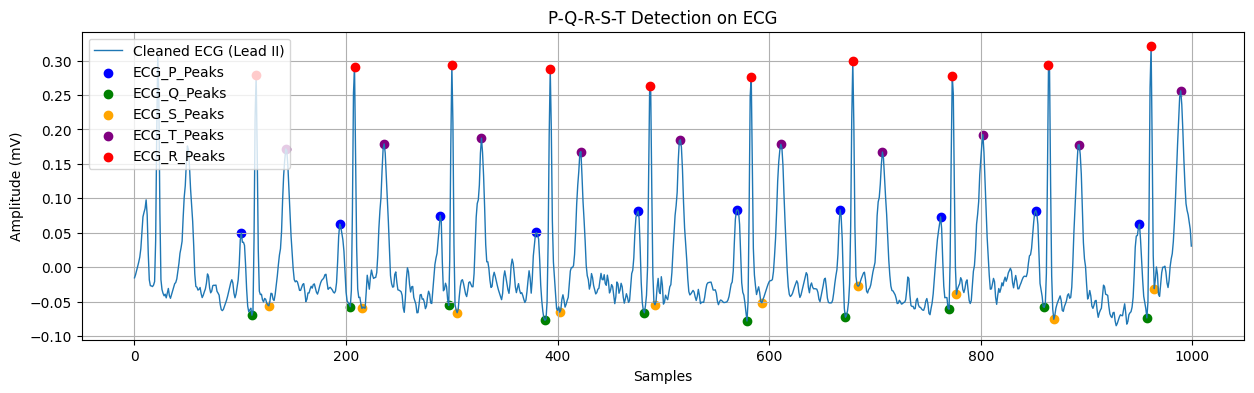

In [17]:
plt.figure(figsize=(15, 4))
plt.plot(ecg_cleaned, label="Cleaned ECG (Lead II)", linewidth=1)

# Plot P, Q, S, T peaks from wave_peaks
for label, color in colors.items():
    if label != "ECG_R_Peaks":  # Skip R here
        indices = wave_peaks.get(label)
        if indices is not None:
            plt.scatter(indices, ecg_cleaned[indices], label=label, color=color)

# ✅ Plot R-peaks separately using r_peaks
plt.scatter(r_peaks, ecg_cleaned[r_peaks], color="red", label="ECG_R_Peaks", zorder=5)

# ✅ Move legend to top-left
plt.legend(loc="upper left")

plt.title("P-Q-R-S-T Detection on ECG")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

